<a href="https://colab.research.google.com/github/linghduoduo/Deep-Learning/blob/master/3_PyTorch_tutorial_newVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch 模型建構與訓練基礎介紹 -- PyTorch Training Steps & Tips 

In [ ]:
#@markdown **安裝適當的套件版本 Run me to install libraries!**

%%bash
pip install torch==1.2.0    \
      torchvision==0.4.0    \
            numpy==1.17.5   \
       matplotlib==3.1.3    \
           pandas==0.25.3   \
            scipy==1.4.1    \
           pillow==6.2.2    \
           gensim==3.6.0    \
    opencv-python==4.1.2.30 \
     scikit-learn==0.22.1 -q

pip install  tqdm==4.28.1   \
             lime==0.1.1.37 \
             nltk==3.4.5  -q

In [ ]:
#@markdown **下載所需的資料 Download the necessary files here!**

%%bash
COLAB_ICON="${COLAB_ICON}https://miro.medium.com/max/200/"
COLAB_ICON="${COLAB_ICON}1*i_ncmAcN81MRMNRDcenKiw.png"
wget -q -nc -O Colab_icon.png $COLAB_ICON

echo "Hello! I am the data~. :P" > filename.txt

echo "Col0,Col1,Col2,Col3" > data.csv
echo "Row1,data11,data12,data13" >> data.csv
echo "Row2,data21,data22,data23" >> data.csv
echo "Row3,data31,data32,data33" >> data.csv
echo "Row4,data41,data42,data43" >> data.csv
echo "Row5,data51,data52,data53" >> data.csv
echo "Row6,data61,data62,data63" >> data.csv
echo "Row7,data71,data72,data73" >> data.csv
printf "%s" "Row8,data81,data82,data83" >> data.csv

gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' \
    --output food-11.zip # 下載資料集
unzip food-11.zip > unziplog # 解壓縮
rm -f unziplog

wget -q -N https://download.pytorch.org/tutorial/faces.zip
if [ ! -d data ]; then mkdir data; fi
unzip -q -o faces.zip -d data > unziplog
rm -f faces.zip
rm -f unziplog

Downloading...
From: https://drive.google.com/uc?id=19CzXudqN58R3D-1G8KeFWk8UDQwlb8is
To: /content/food-11.zip
1.16GB [00:06, 191MB/s]
replace food-11/testing/0071.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: new name: replace iplog? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [{ENTER}]
replace iplog? [y]es, [n]o, [A]ll, [N]one, [r]ename: error:  invalid response [wget -q -]
replace iplog? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### 載入需要的套件和模組 Libraries

In [ ]:
import os, sys
import time, json, csv
from glob import glob

import numpy as np
import pandas as pd

# %% 深度學習套件 deep learning related 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# %% 視覺化/製圖套件 visualization / plotting
# MacOSX 比較麻煩⋯⋯
from platform import system
if system() == "Darwin":
    import matplotlib
    matplotlib.use('TkAgg')

import matplotlib.pyplot as plt

# %% 圖片處理套件 CV related
import cv2
from PIL import Image
import torchvision
import torchvision.transforms as transforms

# %% 文字處理套件 NLP related
from gensim.models import word2vec

# %% 音訊處理套件 Speech related
# import torchaudio
# import librosa

# %% 好用的進度條和排版工具
##   progress bar and pretty print
from tqdm import tqdm
from pprint import pprint

## 1. 資料前處理 - Data Preprocessing
首先，我們需要將我們的資料整理成 model 可以處理的形式  
First, we need to process our data into forms that can be processed by models.

### 1 -- 資料讀取 - Reading files

#### 文字檔案 - Text Files
這是最簡單的，直接如一般 Python 讀取就好
Simply follows that in other Python programs.

In [ ]:
with open("filename.txt", 'r') as f:
    data = f.read()
print(data)

Hello! I am the data~. :P



#### CSV 檔案 - CSV Files

In [ ]:
with open("data.csv") as f: 
    csv_data = f.read()
print("Here comes a csv data:", 
      '=' * 60, csv_data, '=' * 60, sep='\n')

Here comes a csv data:
Col0,Col1,Col2,Col3
Row1,data11,data12,data13
Row2,data21,data22,data23
Row3,data31,data32,data33
Row4,data41,data42,data43
Row5,data51,data52,data53
Row6,data61,data62,data63
Row7,data71,data72,data73
Row8,data81,data82,data83


##### 1) Python 原生 - Pure Python

In [ ]:
import csv
with open("data.csv", 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    # If you have a "tsv", do this:
    ##  `csv_reader = csv.reader(f, delimiter='\t')`
    csv_data1 = [row for row in csv_reader]
csv_data1

[['Col0', 'Col1', 'Col2', 'Col3'],
 ['Row1', 'data11', 'data12', 'data13'],
 ['Row2', 'data21', 'data22', 'data23'],
 ['Row3', 'data31', 'data32', 'data33'],
 ['Row4', 'data41', 'data42', 'data43'],
 ['Row5', 'data51', 'data52', 'data53'],
 ['Row6', 'data61', 'data62', 'data63'],
 ['Row7', 'data71', 'data72', 'data73'],
 ['Row8', 'data81', 'data82', 'data83']]

##### 2) 使用 Pandas 套件（比較快！） --- Pandas Library (Faster!)

In [ ]:
csv_data2 = pd.read_csv("data.csv")

# Saved as a Pandas dataframe
csv_data2

,Col0,Col1,Col2,Col3
0,Row1,data11,data12,data13
1,Row2,data21,data22,data23
2,Row3,data31,data32,data33
3,Row4,data41,data42,data43
4,Row5,data51,data52,data53
5,Row6,data61,data62,data63
6,Row7,data71,data72,data73
7,Row8,data81,data82,data83


In [ ]:
data_columns = csv_data2.columns
data_columns.values # `.values` to numpy arrays

array(['Col0', 'Col1', 'Col2', 'Col3'], dtype=object)

In [ ]:
try:    # after pandas ver.0.24.0
    data_content = csv_data2.to_numpy()
except: # before pandas ver.0.24.0
    data_content = csv_data2.values
data_content

array([['Row1', 'data11', 'data12', 'data13'],
       ['Row2', 'data21', 'data22', 'data23'],
       ['Row3', 'data31', 'data32', 'data33'],
       ['Row4', 'data41', 'data42', 'data43'],
       ['Row5', 'data51', 'data52', 'data53'],
       ['Row6', 'data61', 'data62', 'data63'],
       ['Row7', 'data71', 'data72', 'data73'],
       ['Row8', 'data81', 'data82', 'data83']], dtype=object)

#### 圖片檔案 --- Image Files

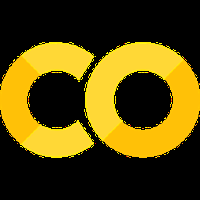

In [ ]:
#@title **看看圖片！ Run me to view image!**
from IPython.display import Image as ImageColab
image = cv2.imread("Colab_icon.png")
im = Image.fromarray(image[..., ::-1])
im.save("Colab_icon.png")
ImageColab('Colab_icon.png')

In [ ]:
# image = cv2.imread("image1.png")
image = cv2.imread("Colab_icon.png")
image.shape

(200, 200, 3)

### 2 -- 資料處理操作 -- Data Manipulation

#### 文字資料 --- Text data

In [ ]:
text = "Hello, world!\nI want to try tabs.\tLike this!"
text_splitted = text.split('\n')
text_splitted = text.splitlines()

# List comprehension
text_splitted = [line.split('\t') 
     for line in text.split('\n')]

#### Numpy 陣列 --- Numpy Array data

In [ ]:
arr1 = np.array([[1, 2], [3, 4], [5, 6]])
arr2 = np.array([[9, 8], [7, 6], [5, 4]])
arr6 = np.random.randint(0, 100, (3, 5, 4))
print(">>> arr1 is ..."); print(arr1)
print(">>> arr2 is ..."); print(arr2)

arr3 = np.concatenate((arr1, arr2), axis=0)
arr4 = np.concatenate((arr1, arr2), axis=1)

arr5 = np.transpose(arr1)
arr7 = np.transpose(arr6, axes=(0, 2, 1))

lst = [3, 76, 4, -45, 0, 6]
arr8 = np.array(lst)
print(f">>> The shape of arr8 is {arr8.shape}.")

arr9 = arr8.astype(np.float)
print(">>> arr9 is ..."); print(arr9)

lst = [[9, 8], [7, 6], [5, 4]]
arr10 = np.array(lst, dtype="uint8")
arr11 = arr10.astype(np.float32)

print(f">>> The type of `lst` is {type(lst)},")
print(f"    but the type of `arr10` is {type(arr10)}.")

new_shape = (1, -1, 3)
arr10_reshaped = arr10.reshape(new_shape)
print(">>> arr10_reshaped is ...")
print(arr10_reshaped)

arr10_transposed = arr10.T
print(">>> arr10_transposed is ...")
print(arr10_transposed)

>>> arr1 is ...
[[1 2]
 [3 4]
 [5 6]]
>>> arr2 is ...
[[9 8]
 [7 6]
 [5 4]]
>>> The shape of arr8 is (6,).
>>> arr9 is ...
[  3.  76.   4. -45.   0.   6.]
>>> The type of `lst` is <class 'list'>,
    but the type of `arr10` is <class 'numpy.ndarray'>.
>>> arr10_reshaped is ...
[[[9 8 7]
  [6 5 4]]]
>>> arr10_transposed is ...
[[9 7 5]
 [8 6 4]]


#### 圖片資料 --- Image data
把原來的圖片做伸縮

In [ ]:
img_shape = (100, 100)
images = [cv2.resize(image, img_shape)]
zeros_reserved = \
    np.zeros((len(images), *img_shape),
                            dtype=np.uint8)
print(images[0].shape)

(100, 100, 3)


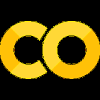

In [ ]:
#@markdown 看轉換的圖片！ View resized image!
im = Image.fromarray(images[0][..., ::-1])
im.save("your_file.png")
ImageColab("your_file.png")

##### 常用的圖片轉換 Data augmentations

```python
import torchvision.transforms as transforms
# Basic transformations
train_transform = transforms.Compose([
    transforms.ToPILImage(), # np.array  --> PIL_image
    transforms.ToTensor()    # PIL_image --> Tensor
])
```

下面有一些重複且被註解掉的部分，是因為版本差異造成。請注意應該只有一個會 work
```python
# For data augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(DEGREE), 
    # transforms.RandomRotation(DEGREE, fill=(0,)),
    # transforms.RandomRotation(DEGREE, 
    #     resample=False, expand=False, center=None),
    transforms.ToTensor()
])

# Feature Scaling, 
#     `mean` and `std` as np.array provided
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(), 
    transforms.Normalize(
        [mean], [std], inplace=False)
    # transforms.Normalize([mean], [std])
])
```

#### 詞向量 --- Word2Vec

In [ ]:
# https://en.wikipedia.org/wiki/Machine_learning

article = '''Machine learning (ML) is the scientific 
study of algorithms and statistical models that 
computer systems use to perform a specific task 
without using explicit instructions, relying on 
patterns and inference instead. It is seen as a 
subset of artificial intelligence. Machine learning 
algorithms build a mathematical model based on sample 
data, known as "training data", in order to make 
predictions or decisions without being explicitly 
programmed to perform the task. Machine learning 
algorithms are used in a wide variety of applications, 
such as email filtering and computer vision, where it 
is difficult or infeasible to develop a conventional 
algorithm for effectively performing the task.
'''[:-1].replace('\n', '')

for punctuation in ",()\"":
    article = article.replace(punctuation, '')
tokenized_sentences = []
for sentence in article.split('.'):
    if sentence == '': continue
    sentence = sentence.strip()
    sentence = sentence[0].lower() + sentence[1:]
    tokenized_sentences.append(sentence.split())

In [ ]:
# 這格有時可能要跑一段時間！ This cell may take time! 
w2vmodel = word2vec.Word2Vec(
                    tokenized_sentences, 
                    size=100, # Word embedding 的維度數
                    window=5, min_count=1,
                    workers=12, iter=5)

### 3 -- 資料準備 --- Dataset / Dataloader Preparation
在處理訓練資料時，進行資料型態的前處理與分批（batch）等是相當麻煩的事。  
PyTorch 提供了一個很好的 dataset 與 dataloader 讓我們進行分裝以利訓練進行，還可以依需求自訂 dataset 的型態  

簡言之，`dataset` 是用來做打包與預處理（例如輸入資料路徑自動讀取）；  
`Dataloader` 則是可以將整個資料集（dataset）按照 batch 進行迭代分裝或 shuffle（會得到一個 iterator 以利 for 迴圈讀取）

其中 `dataset` 必須給予 `__len__`（dataset 大小）與`__getitem__`（取得特定 index 的資料）的定義  
（否則會跳出 `NotImplementedError`）

另外 `Dataloader` 可以自訂 `collate_fn` 決定 batch 的分裝方式，可以參見[這裡](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn)

#### 範例１：隨機資料

In [ ]:
X = np.random.rand(1000, 100, 100, 1)   # 虛構 1000 張 100 x 100 單色圖片
Y = np.random.randint(0, 7, [1000, 10]) # 虛構 1000 個 labels

class RandomDataset(Dataset):
    def __init__(self, data, target):             # 把資料存進 class object
        self.data = data
        self.target = target
    def __len__(self):
        assert len(self.data) == len(self.target) # 確定資料有互相對應
        return len(self.data)
    def __getitem__(self, idx):                     # 定義我們需要取得某筆資料的方式
        return self.data[idx], self.target[idx]

In [ ]:
randomdataset = RandomDataset(X.astype(np.float32), Y.astype(np.float32))
taken_x, taken_y = randomdataset[0] # 原則上可以取得第一筆資料
taken_x.shape, taken_y.shape

((100, 100, 1), (10,))

In [ ]:
# 將 dataset 包裝成 dataloader
randomdataloader = DataLoader(
    randomdataset, batch_size=4,
    shuffle=True, num_workers=4)

In [ ]:
# 跑一個 loop 確認拿到的 batch 是否正確
for batch_x, batch_y in randomdataloader:
    print((batch_x.shape, batch_y.shape))
    break

(torch.Size([4, 100, 100, 1]), torch.Size([4, 10]))


##### 張量資料集 Tensor dataset
這是最常見的形式，因此 PyTorch 本身有提供方便的 `TensorDataset` 給我們使用  
This is the most common form, so we have `TensorDataset` implemented in PyTorch.

```python
torch.utils.data.TensorDataset(data_tensor, target_tensor)
```

如果用 `TensorDataset` 寫，上面就會輕鬆很多

In [ ]:
from torch.utils.data import TensorDataset
# 把資料轉成 Tensor
tsrX, tsrY = torch.tensor(X), torch.tensor(Y)
# 然後就只要一行了！
tsrdataset = TensorDataset(tsrX, tsrY)

# dataloader 本來就相對簡單
tsrdataloader = DataLoader(
    tsrdataset, batch_size=4,
    shuffle=True, num_workers=4)

# 跑一個 loop 確認拿到的 batch 是否正確
for batch_x, batch_y in tsrdataloader:
    print((batch_x.shape, batch_y.shape))
    break

(torch.Size([4, 100, 100, 1]), torch.Size([4, 10]))


實際上資料處理還可以更加複雜，機器學習中資料的錢處理也是相當的學問！  

#### 範例２：MNIST

In [ ]:
from torchvision import datasets, transforms
train_set = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

test_set = datasets.MNIST('../data', train=False, 
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

for batch_x, batch_y in train_loader:
    print((batch_x.shape, batch_y.shape))
    break

(torch.Size([32, 1, 28, 28]), torch.Size([32]))


## 2. Model Construction -- <mark><tt>**torch.nn**</tt></mark>
After data processing, it comes to the *main part* of the implementation of deep learning -- **model construction**.
Most frequently used modules and functions are wrapped under the <mark><tt>**torch.nn**</tt></mark> module.  

Here comes a common syntax --  
```python
import torch.nn as nn
import torch.nn.functional as F
```

### Model -- **`nn.Module`**

This is the basic module for PyTorch Neural network models. To build an NN model, inherit from it.

```python
class MyNNModel(nn.Module):
    def __init__(self):
        super(MyNNModel, self).__init__()
        # other layers or else...
```

### Wrapper -- **`nn.Sequential`**

PyTorch provides a convenient layer wrapper `nn.Sequential` for us.  
We can wrap a couple of layers together and use it for many times.

```python
nn.Sequential(layers)
```

In [ ]:
# Let us have 3 layers
layer1 = nn.Linear(100, 20)
layer2 = nn.Linear(20, 16)
layer3 = nn.Linear(16, 7)

# Data format: 
#    - Input:  100 x 100
#    - Output: 100 x 7
input_data  = torch.randn(100, 100)
output_data = torch.randn(100, 7)

In [ ]:
print("Befor using `nn.Sequential`...")
# Originally, we need to write this.
print(f"The input tensor shape: {input_data.shape}")
out = layer1(input_data)
out = layer2(out)
result = layer3(out)
print(f"The output tensor shape: {result.shape}\n")

Befor using `nn.Sequential`...
The input tensor shape: torch.Size([100, 100])
The output tensor shape: torch.Size([100, 7])



In [ ]:
# If we wrap them together, 
##  we can just view the layers as a block.
print("After using `nn.Sequential`...")
print(f"The input tensor shape: {input_data.shape}")
layer_block = nn.Sequential(
    layer1, layer2, layer3
)
result = layer_block(input_data)
print(f"The output tensor shape: {result.shape}")

After using `nn.Sequential`...
The input tensor shape: torch.Size([100, 100])
The output tensor shape: torch.Size([100, 7])


### 1 -- Model Layers

#### 1) NN
`nn.Linear` -- Often used fully-connected layer
```python
nn.Linear(in_dim, out_dim)
```

In [ ]:
batch_size = 32
"""nn.Linear(in_dim, out_dim)"""
fake_data = torch.randn(batch_size, 128)
print(f"The input data shape:  {fake_data.shape}")
Linear_layer = nn.Linear(128, 32)
print( "The output data shape: "\
      f"{Linear_layer(fake_data).shape}")

The input data shape:  torch.Size([32, 128])
The output data shape: torch.Size([32, 32])


#### 2) CNN

##### Convolution layers
`nn.Conv2d` -- Basic 2D Convolutional Layer
```python
nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
```
Input shape: $(N, C_{in}, H_{in}, W_{in})$  
Output shape: $(N, C_{out}, H_{out}, W_{out})$ where
$$H_{out}=\left \lfloor \cfrac{H_{in}+ 2 \times \text{padding}[0]-\text{dilation}[0]\times(\text{kernel_size}[0]-1)-1}{\text{stride}[0]} \right \rfloor+1$$
$$W_{out}=\left \lfloor \cfrac{H_{in}+ 2 \times \text{padding}[1]-\text{dilation}[1]\times(\text{kernel_size}[1]-1)-1}{\text{stride}[1]} \right \rfloor+1$$

The `[0]`, `[1]` in the formula means the same value if the variable is passed in as an integer. (They can be tuples.)

In [ ]:
fake_data = torch.randn(batch_size, 3, 100, 100)
print(f"The input data shape:  {fake_data.shape}")

The input data shape:  torch.Size([32, 3, 100, 100])


In [ ]:
#@title Deciding channels
input_channels = 3#@param {type:"integer"}
output_channels = 128#@param {type:"integer"}

In [ ]:
#@title Only `kernel_size`
kernel_size =   7#@param {type:"integer"}

Conv_layer1 = nn.Conv2d(input_channels,
                        output_channels, 
                        kernel_size)
output_res1 = Conv_layer1(fake_data)

print("############### Try the following code... ###############\n")
print(f"Conv_layer1 = nn.Conv2d({input_channels}, "\
      f"{output_channels}, "\
      f"{kernel_size})")
print("output_res1 = Conv_layer1(fake_data)")
print("print(f\"The output data shape: {output_res1.shape}\")")
print("\n#########################################################\n")
print("Output `H_out` =",
     f"((⌊100 + 2 × 0 - 1 × ({kernel_size} - 1) - 1⌋ / 1) + 1 =",
      int((100 + 2 * 0 - 1 * (kernel_size - 1) - 1) / 1) + 1)
print(f"The output data shape: {output_res1.shape}")

############### Try the following code... ###############

Conv_layer1 = nn.Conv2d(3, 128, 7)
output_res1 = Conv_layer1(fake_data)
print(f"The output data shape: {output_res1.shape}")

#########################################################

Output `H_out` = ((⌊100 + 2 × 0 - 1 × (7 - 1) - 1⌋ / 1) + 1 = 94
The output data shape: torch.Size([32, 128, 94, 94])


In [ ]:
Conv_layer1 = nn.Conv2d(3, 128, 7)
output_res1 = Conv_layer1(fake_data)
print(f"The output data shape: {output_res1.shape}")

The output data shape: torch.Size([32, 128, 94, 94])


In [ ]:
#@title `kernel_size` and `stride`
kernel_size =   9#@param {type:"integer"}
stride =   3#@param {type:"integer"}

Conv_layer2 = nn.Conv2d(input_channels,
                        output_channels, 
                        kernel_size, 
                        stride)
output_res2 = Conv_layer2(fake_data)

print("############### Try the following code... ###############\n")
print(f"Conv_layer2 = nn.Conv2d({input_channels}, "\
      f"{output_channels}, "\
      f"{kernel_size}, {stride})")
print("output_res2 = Conv_layer2(fake_data)")
print("print(f\"The output data shape: {output_res2.shape}\")")
print("\n#########################################################\n")
print("Output `H_out` =",
     f"((⌊100 + 2 × 0 - 1 × ({kernel_size} - 1) - 1⌋ / {stride}) + 1 =",
      int((100 + 2 * 0 - 1 * (kernel_size - 1) - 1) / stride) + 1)
print( "The output data shape: "\
      f"{output_res2.shape}")

############### Try the following code... ###############

Conv_layer2 = nn.Conv2d(3, 128, 9, 3)
output_res2 = Conv_layer2(fake_data)
print(f"The output data shape: {output_res2.shape}")

#########################################################

Output `H_out` = ((⌊100 + 2 × 0 - 1 × (9 - 1) - 1⌋ / 3) + 1 = 31
The output data shape: torch.Size([32, 128, 31, 31])


In [ ]:
Conv_layer2 = nn.Conv2d(3, 128, 9, 3)
output_res2 = Conv_layer2(fake_data)
print(f"The output data shape: {output_res2.shape}")

The output data shape: torch.Size([32, 128, 31, 31])


In [ ]:
#@title `kernel_size` and `padding`
kernel_size =   3#@param {type:"integer"}
padding =   1#@param {type:"integer"}

Conv_layer3 = nn.Conv2d(input_channels,
                        output_channels, 
                        kernel_size, 
                        padding=padding)
output_res3 = Conv_layer3(fake_data)

print("############### Try the following code... ###############\n")
print(f"Conv_layer3 = nn.Conv2d({input_channels}, "\
      f"{output_channels}, "\
      f"{kernel_size}, padding={padding})")
print("output_res3 = Conv_layer3(fake_data)")
print("print(f\"The output data shape: {output_res3.shape}\")")
print("\n#########################################################\n")
print("Output `H_out` =",
     f"⌊((100 + 2 × {padding} - 1 × ({kernel_size} - 1) - 1⌋ / 1) + 1 =",
      int((100 + 2 * padding - 1 * (kernel_size - 1) - 1) / 1) + 1)
print( "The output data shape: "\
      f"{output_res3.shape}")

############### Try the following code... ###############

Conv_layer3 = nn.Conv2d(3, 128, 3, padding=1)
output_res3 = Conv_layer3(fake_data)
print(f"The output data shape: {output_res3.shape}")

#########################################################

Output `H_out` = ⌊((100 + 2 × 1 - 1 × (3 - 1) - 1⌋ / 1) + 1 = 100
The output data shape: torch.Size([32, 128, 100, 100])


In [ ]:
Conv_layer3 = nn.Conv2d(3, 128, 3, padding=1)
output_res3 = Conv_layer3(fake_data)
print(f"The output data shape: {output_res3.shape}")


The output data shape: torch.Size([32, 128, 100, 100])


In [ ]:
#@title `kernel_size`, `stride` and `padding`
kernel_size =   6#@param {type:"integer"}
stride =   2#@param {type:"integer"}
padding =   3#@param {type:"integer"}

Conv_layer4 = nn.Conv2d(input_channels,
                        output_channels, 
                        kernel_size, 
                        stride, 
                        padding)
output_res4 = Conv_layer4(fake_data)

print("############### Try the following code... ###############\n")
print(f"Conv_layer4 = nn.Conv2d({input_channels}, "\
      f"{output_channels}, "\
      f"{kernel_size}, {stride}, {padding})")
print("output_res4 = Conv_layer4(fake_data)")
print("print(f\"The output data shape: {output_res4.shape}\")")
print("\n#########################################################\n")
print("Output `H_out` =",
     f"⌊((100 + 2 × {padding} - 1 × ({kernel_size} - 1) - 1⌋ / {stride}) + 1 =",
      int((100 + 2 * padding - 1 * (kernel_size - 1) - 1) / stride) + 1)
print( "The output data shape: "\
      f"{output_res4.shape}")

############### Try the following code... ###############

Conv_layer4 = nn.Conv2d(3, 128, 6, 2, 3)
output_res4 = Conv_layer4(fake_data)
print(f"The output data shape: {output_res4.shape}")

#########################################################

Output `H_out` = ⌊((100 + 2 × 3 - 1 × (6 - 1) - 1⌋ / 2) + 1 = 51
The output data shape: torch.Size([32, 128, 51, 51])


In [ ]:
Conv_layer4 = nn.Conv2d(3, 128, 6, 2, 3)
output_res4 = Conv_layer4(fake_data)
print(f"The output data shape: {output_res4.shape}")

The output data shape: torch.Size([32, 128, 51, 51])


##### Pooling layers
`nn.MaxPool2d` -- Basic 2D Max Pooling Layer
```python
nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1)
# stride default: kernel_size
```
Input shape: $(N, C, H_{in}, W_{in})$  
Output shape: $(N, C, H_{out}, W_{out})$ where
$$H_{out}=\left \lfloor \cfrac{H_{in}+ 2 \times \text{padding}[0]-\text{dilation}[0]\times(\text{kernel_size}[0]-1)-1}{\text{stride}[0]} \right \rfloor+1$$
$$W_{out}=\left \lfloor \cfrac{H_{in}+ 2 \times \text{padding}[1]-\text{dilation}[1]\times(\text{kernel_size}[1]-1)-1}{\text{stride}[1]} \right \rfloor+1$$

In [ ]:
fake_data = torch.randn(batch_size, 3, 100, 100)
print(f"The input data shape:  {fake_data.shape}")

The input data shape:  torch.Size([32, 3, 100, 100])


In [ ]:
#@title Only `kernel_size` {display-mode:"form"}
kernel_size =   6#@param {type:"integer"}

MaxPool_layer1 = nn.MaxPool2d(kernel_size)
output_res1 = MaxPool_layer1(fake_data)

print("############### Try the following code... ###############\n")
print(f"MaxPool_layer1 = nn.MaxPool2d({kernel_size})")
print("output_res1 = MaxPool_layer1(fake_data)")
print("print(f\"The output data shape: {output_res1.shape}\")")
print("\n#########################################################\n")

print("Output `H_out` =",
     f"⌊((100 + 2 × 0 - 1 × ({kernel_size} - 1) - 1) / {kernel_size}⌋ + 1 =",
      int((100 + 2 * 0 - 1 * (kernel_size - 1) - 1) / kernel_size) + 1)
print(f"The output data shape: {output_res1.shape}")

############### Try the following code... ###############

MaxPool_layer1 = nn.MaxPool2d(6)
output_res1 = MaxPool_layer1(fake_data)
print(f"The output data shape: {output_res1.shape}")

#########################################################

Output `H_out` = ⌊((100 + 2 × 0 - 1 × (6 - 1) - 1) / 6⌋ + 1 = 16
The output data shape: torch.Size([32, 3, 16, 16])


In [ ]:
MaxPool_layer1 = nn.MaxPool2d(6)
output_res1 = MaxPool_layer1(fake_data)
print(f"The output data shape: {output_res1.shape}")

The output data shape: torch.Size([32, 3, 16, 16])


In [ ]:
# @title `kernel_size` ≠ `stride` {display-mode:"form"}
kernel_size =   7#@param {type:"integer"}
stride =   9#@param {type:"integer"}

MaxPool_layer2 = nn.MaxPool2d(kernel_size, stride)
output_res2 = MaxPool_layer2(fake_data)

print("############### Try the following code... ###############\n")
print(f"MaxPool_layer2 = nn.MaxPool2d({kernel_size}, {stride})")
print("output_res2 = MaxPool_layer2(fake_data)")
print("print(f\"The output data shape: {output_res2.shape}\")")
print("\n#########################################################\n")

print("Output `H_out` =",
     f"⌊((100 + 2 × 0 - 1 × ({kernel_size} - 1) - 1⌋ / {stride}) + 1 =",
      int((100 + 2 * 0 - 1 * (kernel_size - 1) - 1) / stride) + 1)
print(f"The output data shape: {output_res2.shape}")

############### Try the following code... ###############

MaxPool_layer2 = nn.MaxPool2d(7, 9)
output_res2 = MaxPool_layer2(fake_data)
print(f"The output data shape: {output_res2.shape}")

#########################################################

Output `H_out` = ⌊((100 + 2 × 0 - 1 × (7 - 1) - 1⌋ / 9) + 1 = 11
The output data shape: torch.Size([32, 3, 11, 11])


In [ ]:
MaxPool_layer2 = nn.MaxPool2d(7, 9)
output_res2 = MaxPool_layer2(fake_data)
print(f"The output data shape: {output_res2.shape}")

The output data shape: torch.Size([32, 3, 11, 11])


In [ ]:
#@title `kernel_size`, `stride` and `padding`
kernel_size =   5#@param {type:"integer"}
stride =   3#@param {type:"integer"}
padding =   2#@param {type:"integer"}

MaxPool_layer3 = nn.MaxPool2d(kernel_size, stride, padding)
output_res3 = MaxPool_layer3(fake_data)

print("############### Try the following code... ###############\n")
print(f"MaxPool_layer3 = nn.MaxPool2d({kernel_size}, {stride}, {padding})")
print("output_res3 = MaxPool_layer3(fake_data)")
print("print(f\"The output data shape: {output_res3.shape}\")")
print("\n#########################################################\n")

print("Output `H_out` =",
     f"⌊((100 + 2 × {padding} - 1 × ({kernel_size} - 1) - 1⌋ / {stride}) + 1 =",
      int((100 + 2 * padding - 1 * (kernel_size - 1) - 1) / stride) + 1)
print( "The output data shape: "\
      f"{output_res3.shape}")

############### Try the following code... ###############

MaxPool_layer3 = nn.MaxPool2d(5, 3, 2)
output_res3 = MaxPool_layer3(fake_data)
print(f"The output data shape: {output_res3.shape}")

#########################################################

Output `H_out` = ⌊((100 + 2 × 2 - 1 × (5 - 1) - 1⌋ / 3) + 1 = 34
The output data shape: torch.Size([32, 3, 34, 34])


In [ ]:
MaxPool_layer3 = nn.MaxPool2d(5, 3, 2)
output_res3 = MaxPool_layer3(fake_data)
print(f"The output data shape: {output_res3.shape}")

The output data shape: torch.Size([32, 3, 34, 34])


#### 3) RNN

##### Embedding layers

In [ ]:
Embedding_layer = nn.Embedding(10, 3)
fake_data = torch.LongTensor([[1, 2, 4, 5], [4, 3, 2, 9]])
print("""
The input data shape:  {}
The output data shape: {}""".format
(fake_data.shape, Embedding_layer(fake_data).shape)[1:])

The input data shape:  torch.Size([2, 4])
The output data shape: torch.Size([2, 4, 3])


###### Loading Word2Vec models

In [ ]:
Embedding_layer = nn.Embedding(*(w2vmodel.wv.vectors.shape))
Embedding_layer.weight = nn.Parameter(
    torch.FloatTensor(w2vmodel.wv.vectors))
fix_embedding = True
Embedding_layer.weight.requires_grad = not fix_embedding

word2index = {word: ind \
    for ind, word in enumerate(w2vmodel.wv.index2word)}
print("Our embedding dimesion is {}.".format(w2vmodel.wv.vector_size))

Our embedding dimesion is 100.


In [ ]:
sent_ori = "The model is used for training."
sent = sent_ori.replace('.', '').lower()
list_of_indices = [word2index[w] for w in sent.split()]
tensor_of_indices = torch.LongTensor(list_of_indices)

print(
    "The sentence is:\n   \"", sent_ori + '"',
"""\nWe pass {} tokens into the model,
    which is treated as a LongTensor with shape "{}".
The embedding layer transformed it to shape "{}".
""".format(len(list_of_indices), 
           tensor_of_indices.shape, 
           Embedding_layer(tensor_of_indices).shape))

The sentence is:
   " The model is used for training." 
We pass 6 tokens into the model,
    which is treated as a LongTensor with shape "torch.Size([6])".
The embedding layer transformed it to shape "torch.Size([6, 100])".



##### RNN layers (LSTM, GRU)

In [ ]:
LSTM_layer = nn.LSTM(100, 80, 2)
fake_data = torch.randn(5, 3, 100)
h0 = torch.randn(2, 3, 80)
c0 = torch.randn(2, 3, 80)
output, (hn, cn) = LSTM_layer(fake_data, (h0, c0))
print("""Input shape: {}
Output shape: {}""".format(
fake_data.shape, (output.shape, (hn.shape, cn.shape))))

Input shape: torch.Size([5, 3, 100])
Output shape: (torch.Size([5, 3, 80]), (torch.Size([2, 3, 80]), torch.Size([2, 3, 80])))


In [ ]:
GRU_layer = nn.GRU(100, 80, 2)
fake_data = torch.randn(5, 3, 100)
h0 = torch.randn(2, 3, 80)
output, hn = GRU_layer(fake_data, h0)
print("""Input shape: {}
Output shape: {}""".format(
fake_data.shape, (output.shape, hn.shape)))

Input shape: torch.Size([5, 3, 100])
Output shape: (torch.Size([5, 3, 80]), torch.Size([2, 3, 80]))


### 2 -- Activation functions  
You have two choices for your activation functions:

1. In `torch.nn`, we have model layer modules.  
2. In `torch.nn.functionals`, we have function implementations of activation functions, loss functions, and so on.

Just to list a few...  

| activation function | `torch.nn as nn`                    | `torch.nn.functional as F` |
|:-------------------:| ----------------------------------- | -------------------------- |
| Sigmoid             | `nn.Sigmoid()`                      | `F.sigmoid`                |
| Softmax             | `nn.Softmax(dim=None)`              | `F.softmax`                |
| ReLU                | `nn.ReLU()`                         | `F.relu`                   |
| LeakyReLU           | `nn.LeakyReLU(negative_slope=0.01)` | `F.leaky_relu`             |
| Tanh                | `nn.Tanh()`                         | `F.tanh`                   |
| GELU                | `nn.GELU()`                         | `F.gelu`                   |
| ReLU6               | `nn.ReLU6()`                        | `F.relu6`                  |

<h2>Python Tips</h2>  
<h3>Functions vs. Objects</h3>  

What you get from calling `nn.Sigmoid()` (and others...) is an <b><mark>object</mark></b> initialized from the module.  
Hence, if you want to pass a tensor to that "layer object", you should write this:

```python
# `x` is a tensor.
activation = nn.Sigmoid() # Note that this is a "constructor"!
out = activation(x)       # i.e. `out = nn.Sigmoid()(x)` is valid,
                          # but the object is discarded if you do that.
```

On the other hand, if you simply want to use functions, do this:
```python
# `x` is a tensor.
out = F.sigmoid(x)        # Since `F.sigmoid` is already a "function"!
```

For most time, <b><mark>both are valid</mark></b>. It's just two coding styles.

### 3 -- Loss functions
Here, you also have two choices for your loss functions:

| loss functions              | `torch.nn as nn`     | `torch.nn.functional as F`
|:--------------------------- | -------------------- | ----------------------------------------
| Mean Square Error           | `MSELoss()`          | `F.mse_loss(input, target)`
| Cross Entropy (Multi-label) | `CrossEntropyLoss()` | `F.cross_entropy(input, target)`
| Binary Cross Entropy        | `BCELoss()`          | `F.binary_cross_entropy(input, target)`
| Negative Log Likelihood     | `NLLLoss()`          | `F.nll_loss(F.log_softmax(input), target)`

### 4 -- 優化器 --- Optimizers
用來更新參數的方法（`SGD`、`Adagrad`、`Adam`⋯⋯）  
在 PyTorch 中要經過 `backward()` 函數計算 gradient，  
而在這之前要先用 `optim.zero_grad()` 將 gradient 清掉，否則 PyTorch 會將 gradient 累加起來

（以下請注意 model 參數更新的方向）

In [ ]:
small_model = nn.Linear(3, 7)

print("Take a look at model params:")
print(small_model.weight)

X, Y = torch.rand(3,), torch.rand(7,)
print("\nGiven input X:")
print(X)

print("\nAnd target Y:")
print(Y)

optim = torch.optim.SGD(
    small_model.parameters(), lr=1e-2)
mse_loss = nn.MSELoss()

print("\nThe output Y:")
temp_Y = small_model(X)
print(temp_Y)


print("\nCalculate their MSE Loss = ", end='')
loss = mse_loss(temp_Y, Y)
print(loss.item())

print("\n##### Update a step! #####")
optim.zero_grad()
loss.backward()
optim.step()

print("\nTake a look at \"updated\"model params:")
print(small_model.weight)
updated_params = small_model.weight.data

Take a look at model params:
Parameter containing:
tensor([[ 0.2741, -0.0400,  0.3174],
        [ 0.4538, -0.2445, -0.1900],
        [ 0.0368,  0.3594, -0.2954],
        [-0.3002, -0.1828,  0.5202],
        [-0.0783, -0.5013, -0.1427],
        [ 0.0558,  0.2025,  0.0199],
        [-0.1796,  0.2220, -0.0274]], requires_grad=True)

Given input X:
tensor([0.6425, 0.5494, 0.2037])

And target Y:
tensor([0.3314, 0.3200, 0.2782, 0.9563, 0.9515, 0.4855, 0.1262])

The output Y:
tensor([-0.2295,  0.1076,  0.6899,  0.0077, -0.4212,  0.2130,  0.0091],
       grad_fn=<AddBackward0>)

Calculate their MSE Loss = 0.4859066605567932

##### Update a step! #####

Take a look at "updated"model params:
Parameter containing:
tensor([[ 0.2751, -0.0392,  0.3177],
        [ 0.4542, -0.2441, -0.1899],
        [ 0.0361,  0.3588, -0.2956],
        [-0.2985, -0.1814,  0.5207],
        [-0.0758, -0.4992, -0.1419],
        [ 0.0563,  0.2029,  0.0201],
        [-0.1794,  0.2222, -0.0273]], requires_grad=True)


### 5 -- Normalization
PyTorch 提供不少 normalization 的方法，在初期用得到的主要是 CNN 的 batch normalization
```python
nn.BatchNorm2d(num_features)
```

## 3. Training (Validation) / Fine-Tuning
先像上面一樣處理隨機資料

In [ ]:
from torch.utils.data import TensorDataset

# Training
X = np.random.rand(1000, 100, 100, 1)   # 虛構 1000 張 100 x 100 單色圖片
Y = np.random.randint(0, 7, [1000, 10]) # 虛構 1000 個 labels

X, Y = X.astype(np.float32), Y.astype(np.float32)
tsrX, tsrY = torch.tensor(X), torch.tensor(Y)
tsrdataset = TensorDataset(tsrX, tsrY)

tsrdataloader = DataLoader(
    tsrdataset, batch_size=4,
    shuffle=True, num_workers=4)

# Validation
vX = np.random.rand(100, 100, 100, 1)   # 虛構 100 張 100 x 100 單色圖片
vY = np.random.randint(0, 7, [100, 10]) # 虛構 100 個 labels

vX, vY = vX.astype(np.float32), vY.astype(np.float32)
vtsrX, vtsrY = torch.tensor(vX), torch.tensor(vY)
vtsrdataset = TensorDataset(tsrX, tsrY)

vtsrdataloader = DataLoader(
    vtsrdataset, batch_size=4,
    shuffle=False, num_workers=4) # Validation 不需要 shuffle

# Testing
tX = np.random.rand(100, 100, 100, 1)   # 虛構 100 張 100 x 100 單色圖片
tY = np.random.randint(0, 7, [100, 10]) # 虛構 100 個 labels

tX, tY = tX.astype(np.float32), tY.astype(np.float32)
ttsrX, ttsrY = torch.tensor(tX), torch.tensor(tY)
ttsrdataset = TensorDataset(tsrX, tsrY)

ttsrdataloader = DataLoader(
    ttsrdataset, batch_size=4,
    shuffle=False, num_workers=4) # Testing 不需要 shuffle

在訓練之前，先根據我們前面全部的東西搭一個簡單的 model

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(10000, 500),
            nn.Linear(500, 10))

    def forward(self, x):
        # 傳入 model 的函數會經過 forward 做 inference
        x = x.view(x.size(0), -1)
        return self.fc(x)

simpleNN = SimpleNN()

接著準備 optimizer 跟 loss function

In [ ]:
optim = torch.optim.Adam(simpleNN.parameters(),
                         lr=1e-4)
criterion = nn.MSELoss()

接著進入 training  
Training 的本質就是跑一個迴圈，在每一次（叫一個 **epoch**）要做的事有——
1. 載入資料
1. 經過 model 跑一次
1. 比對資料的正確性，算誤差（loss）
1. 把梯度清掉，然後根據這次誤差算新的梯度
1. 根據 optimizer 更新參數
1. 為了方便觀察，將本次 epoch 訓練的變化顯示出來，包括
    - 進度條（觀察訓練快慢）
    - batch loss （這個有時候會輸出太多東西）
    - epoch loss （記得累計並除掉資料數量）
    - 記錄到其他變數中（方便作圖）
    - 記錄到 Tensorboard 中（SummaryWriter）

為了避免 overfit，我們每個 epoch 還會進行一次 validation，事情少一些，變成——
1. 載入資料
1. 經過 model 跑一次
1. 比對資料的正確性，算誤差（loss）
1. 為了方便觀察，將本次 epoch validate 的結果顯示出來，包括
    - 進度條（觀察訓練快慢）
    - batch loss （這個有時候會輸出太多東西）
    - epoch loss （記得累計並除掉資料數量）
    - 記錄到其他變數中（方便作圖）
    - 記錄到 Tensorboard 中（SummaryWriter）


In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
    simpleNN.train()
    epoch_loss = 0.0
    for x, y in tsrdataloader:
        y_hat = simpleNN(x)
        loss = criterion(y, y_hat)
        optim.zero_grad()
        loss.backward()
        optim.step()
        epoch_loss += loss.item()
    average_epoch_loss = epoch_loss / len(tsrdataset)
    print(f"Training   Epoch {epoch + 1:2d}: Loss = {average_epoch_loss:.4f}")

    simpleNN.eval()
    vepoch_loss = 0.0
    for x, y in vtsrdataloader:
        y_hat = simpleNN(x)
        loss = criterion(y, y_hat)
        vepoch_loss += loss.item()
    vaverage_epoch_loss = vepoch_loss / len(vtsrdataset)
    print(f"Validation Epoch {epoch + 1:2d}: Loss = {vaverage_epoch_loss:.4f}")

Training   Epoch  1: Loss = 1.1976
Validation Epoch  1: Loss = 0.8974
Training   Epoch  2: Loss = 0.9631
Validation Epoch  2: Loss = 0.8561
Training   Epoch  3: Loss = 0.7902
Validation Epoch  3: Loss = 0.6162
Training   Epoch  4: Loss = 0.6237
Validation Epoch  4: Loss = 0.5360
Training   Epoch  5: Loss = 0.4898
Validation Epoch  5: Loss = 0.3594
Training   Epoch  6: Loss = 0.3460
Validation Epoch  6: Loss = 0.2413
Training   Epoch  7: Loss = 0.2222
Validation Epoch  7: Loss = 0.1503
Training   Epoch  8: Loss = 0.1479
Validation Epoch  8: Loss = 0.1421
Training   Epoch  9: Loss = 0.0847
Validation Epoch  9: Loss = 0.0547
Training   Epoch 10: Loss = 0.0500
Validation Epoch 10: Loss = 0.0412


嘛⋯⋯畢竟是隨機生成的，所以發生 overfit 什麼的也不要太意外，不過有時好像會 train 起來？？！

覺得跑很慢嗎？我們有 GPU 為什麼不用呢？？！來看看怎麼用！

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device # Check if GPU available
# 其實寫 x.to(device) 之外也可以寫 x.cuda()
# 但是前者會自動根據環境決定是否使用 GPU 比較彈性

'cuda'

In [ ]:
simpleNN = SimpleNN()
simpleNN.to(device)                           # 把 model 移到 GPU 計算
optim = torch.optim.Adam(
    simpleNN.parameters(), lr=1e-4)
criterion = nn.MSELoss()

EPOCHS = 10
for epoch in range(EPOCHS):
    simpleNN.train()
    epoch_loss = 0.0
    for x, y in tsrdataloader:
        y_hat = simpleNN(x.to(device))        # 把 x tensor 移到 GPU 計算
        loss = criterion(y.to(device), y_hat) # 把 y tensor 移到 GPU 計算，
                                              ##  y_hat 因為是從 GPU model input GPU Tensor 出來的
                                              ##  所以不用再次 .to(device) 當然要也是沒差啦 =_=|||
        optim.zero_grad()
        loss.backward()
        optim.step()
        epoch_loss += loss.item()
    average_epoch_loss = epoch_loss / len(tsrdataset)
    print(f"Training   Epoch {epoch + 1:2d}: Loss = {average_epoch_loss:.4f}")

    simpleNN.eval()
    vepoch_loss = 0.0
    for x, y in vtsrdataloader:
        y_hat = simpleNN(x.to(device))
        loss = criterion(y.to(device), y_hat)
        vepoch_loss += loss.item()
    vaverage_epoch_loss = vepoch_loss / len(vtsrdataset)
    print(f"Validation Epoch {epoch + 1:2d}: Loss = {vaverage_epoch_loss:.4f}")

Training   Epoch  1: Loss = 1.1831
Validation Epoch  1: Loss = 0.9545
Training   Epoch  2: Loss = 0.9413
Validation Epoch  2: Loss = 0.8006
Training   Epoch  3: Loss = 0.7970
Validation Epoch  3: Loss = 0.5749
Training   Epoch  4: Loss = 0.6074
Validation Epoch  4: Loss = 0.4643
Training   Epoch  5: Loss = 0.4606
Validation Epoch  5: Loss = 0.3617
Training   Epoch  6: Loss = 0.3210
Validation Epoch  6: Loss = 0.2529
Training   Epoch  7: Loss = 0.2151
Validation Epoch  7: Loss = 0.1599
Training   Epoch  8: Loss = 0.1299
Validation Epoch  8: Loss = 0.0795
Training   Epoch  9: Loss = 0.0788
Validation Epoch  9: Loss = 0.0532
Training   Epoch 10: Loss = 0.0456
Validation Epoch 10: Loss = 0.0273


<h1><mark><b><large>快多了是吧！</large></b></mark></h1>

### -- Model saving / loading (checkpoints)

In [ ]:
# Save model
simpleNN.cpu() # 先移回 CPU
torch.save(simpleNN.state_dict(), "randmodel.model")

# Load model
model2 = SimpleNN()
model2.load_state_dict(torch.load("randmodel.model"))

<All keys matched successfully>

In [ ]:
# 確認是同一個 model
torch.equal(model2(x), simpleNN(x))

True

## 4. Testing / Evaluation
這裡當然也可以開 GPU，用法相同

In [ ]:
simpleNN.eval()
tepoch_loss = 0.0
for x, y in ttsrdataloader:
    y_hat = simpleNN(x)
    loss = criterion(y, y_hat)
    tepoch_loss += loss.item()
taverage_epoch_loss = tepoch_loss / len(ttsrdataset)
print(f"Testing Loss = {taverage_epoch_loss:.4f}")

Testing Loss = 0.0273


## 5. Result Post-processing

### 1 -- Saving files

In [ ]:
with open("loss.txt", 'w') as f: f.write(str(taverage_epoch_loss))

如果已經把答案存成一個 np.array 或 list，叫做 `answer`

```python
with open("result.csv", 'w') as f:
    f.write("index,ans\n")
    for idx, i in enumerate(answer):
        f.write(f"{idx},{i}\n")
```

### 2 -- Kaggle Upload
Kaggle 有提供方便的 API 可以直接在 Colab 或是 terminal 上傳，只要先弄好 token，以下列指令
```bash
kaggle competitions submit -c <competition_name> -f <filename> -m <message>
```
就可以上傳，例如作業３
```bash
kaggle competitions submit -c ml2020spring-hw3 -f result.csv -m "The first try!"
```

另外要看自己的 submissions
```bash
# kaggle competitions submissions -c <competition_name>
  kaggle competitions submissions -c ml2020spring-hw3
```
或是排行榜
```bash
# kaggle competitions leaderboard -c <competition_name> --show
  kaggle competitions leaderboard -c ml2020spring-hw3 --show
```
（記得把競賽名對應改掉）

### 3 -- Colaboratory / Kaggle Notebook

你現在在用的這個環境本質是 Jupyter Notebook，Kaggle 也有提供一樣的環境可以操作   
（不過在比賽中還是不要用的好，大家都想先藏招嘛！ B-) ） 

![](https://i.imgur.com/YCiTKl9.png)

另外 Jupyter Notebook 也是可以開本地端的（如去年和前年有 DeepQ 贊助運算資源即是以此為介面）

## 6. Visualization

### TensorBoard

In [ ]:
%load_ext tensorboard

In [ ]:
import os
logs_base_dir = "runs"
os.makedirs(logs_base_dir, exist_ok=True)

In [ ]:
%tensorboard --logdir {logs_base_dir}

In [ ]:
from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter()

simpleNN = SimpleNN()
simpleNN.to(device)                           # 把 model 移到 GPU 計算
optim = torch.optim.Adam(
    simpleNN.parameters(), lr=1e-4)
loss = nn.MSELoss()

EPOCHS = 100
for epoch in range(EPOCHS):
    simpleNN.train()
    epoch_loss = 0.0
    for x, y in tsrdataloader:
        y_hat = simpleNN(x.to(device))        # 把 x tensor 移到 GPU 計算
        loss = criterion(y.to(device), y_hat) # 把 y tensor 移到 GPU 計算，
                                              ##  y_hat 因為是從 GPU model input GPU Tensor 出來的
                                              ##  所以不用再次 .to(device) 當然要也是沒差啦 =_=|||
        optim.zero_grad()
        loss.backward()
        optim.step()
        epoch_loss += loss.item()
    average_epoch_loss = epoch_loss / len(tsrdataset)
    print(f"Training   Epoch {epoch + 1:2d}: Loss = {average_epoch_loss:.4f}")
    tb.add_scalar("Loss/train", average_epoch_loss, epoch + 1)

    simpleNN.eval()
    vepoch_loss = 0.0
    for x, y in vtsrdataloader:
        y_hat = simpleNN(x.to(device))
        loss = criterion(y.to(device), y_hat)
        vepoch_loss += loss.item()
    vaverage_epoch_loss = vepoch_loss / len(vtsrdataset)
    print(f"Validation Epoch {epoch + 1:2d}: Loss = {vaverage_epoch_loss:.4f}")
    tb.add_scalar("Loss/val", vaverage_epoch_loss, epoch + 1)
tb.close()

應該會像這樣子（左下角只會有一個顏色才是，此處請忽略）
![](https://i.imgur.com/25qVrAH.png)

## 7. GPU Usage

In [ ]:
%%bash
nvidia-smi
echo
echo "沒有跑出來請看下面"

Wed Mar 25 22:22:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    32W / 250W |    877MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### 1 -- Colaboratory
1. 如果不知道怎麼切 GPU 的，看左上角  
   ![](https://i.imgur.com/ZuZSvKe.png)  

2. 然後  
   ![](https://i.imgur.com/wLmRD3V.png)  
   其實還有 TPU 可以用，就自己去研究吧！


### 2 -- PBS Usage
[這裡](https://asciinema.org/a/T10wcvFwIzXgH4ZdERexBjtKa)有我之前錄製的用法，如果有人有機會用到計中或臺灣杉之類的排程工作站可以學一下

In [ ]:
%%html
<script id="asciicast-T10wcvFwIzXgH4ZdERexBjtKa" src="https://asciinema.org/a/T10wcvFwIzXgH4ZdERexBjtKa.js" async></script>

## TODO for next version
- [ ] argparse
- [ ] Transformer 用法
- [ ] Colab 其他進階用法 

### Useful tips
-  Save at best
-  Early Stopping
-  Learning rate scheduler

### Visualization
-  Matplotlib Usage

### Jupyter / VSCode （Connect to runtime）

### More Examples
- [ ] MNIST